In [1]:
# Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [6]:
# Đường dẫn tới file CSV đã giải nén
csv_path = r"C:\Users\quang\Downloads\archive\StudentPerformanceFactors.csv"

# Đọc dữ liệu
df = pd.read_csv(csv_path)
df.head()


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [7]:
# Tổng quan dữ liệu
print(df.info())

# Xử lý dữ liệu rỗng
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [8]:
from sklearn.preprocessing import LabelEncoder

# Mã hóa cột phân loại sang dữ liệu số
object_columns = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

for col in object_columns:
    df[col] = encoder.fit_transform(df[col])


In [9]:
# Giả định rare event là điểm số < 10% thấp nhất
low_score_threshold = df['Exam_Score'].quantile(0.1)

# Tạo cột đánh dấu sự kiện hiếm
df['rare_event'] = np.where(df['Exam_Score'] < low_score_threshold, 1, 0)


In [10]:
# Tính tương quan
correlations = df.corr()['Exam_Score'].drop('Exam_Score')
selected_features = correlations[correlations.abs() > 0.1].index.tolist()

# Chọn các đặc trưng liên quan
X = df[selected_features]
y = df['Exam_Score']


In [11]:
# Huấn luyện mô hình
linear_model = LinearRegression()
linear_model.fit(X, y)

# Dự đoán và thêm cột dự đoán vào DataFrame
df['predicted_score'] = linear_model.predict(X)


In [12]:
# Tính Mean Squared Error (MSE)
mse = mean_squared_error(df['Exam_Score'], df['predicted_score'])
print("Mean Squared Error:", mse)

# Tính R-squared
r2 = r2_score(df['Exam_Score'], df['predicted_score'])
print("R-squared:", r2)


Mean Squared Error: 6.004012686174472
R-squared: 0.6080596185411167


In [13]:
# Hàm tạo mẫu đối nghịch
def generate_adversarial_samples(df, model, selected_features, epsilon=0.1):
    X_original = df[selected_features].copy()
    noise = np.random.uniform(-epsilon, epsilon, X_original.shape)
    X_adversarial = X_original + noise
    X_adversarial = np.clip(X_adversarial, 0, 1)
    adversarial_predictions = model.predict(X_adversarial)
    
    df['original_prediction'] = model.predict(X_original)
    df['adversarial_prediction'] = adversarial_predictions
    df['prediction_shift'] = df['adversarial_prediction'] - df['original_prediction']
    
    return df, X_adversarial


In [14]:
# Sinh dữ liệu đối nghịch
epsilon = 0.05  # Mức nhiễu nhỏ
df_adversarial, X_adversarial = generate_adversarial_samples(df, linear_model, selected_features, epsilon)

# Đánh giá mức thay đổi trung bình của dự đoán
mean_shift = df_adversarial['prediction_shift'].mean()
print("Mức thay đổi trung bình của dự đoán:", mean_shift)

# Tỷ lệ mẫu có độ lệch lớn hơn ngưỡng
threshold = 0.1
sensitive_samples_ratio = (abs(df_adversarial['prediction_shift']) > threshold).mean()
print("Tỷ lệ mẫu nhạy cảm (độ lệch > 0.1):", sensitive_samples_ratio)


Mức thay đổi trung bình của dự đoán: -22.7540776764675
Tỷ lệ mẫu nhạy cảm (độ lệch > 0.1): 1.0


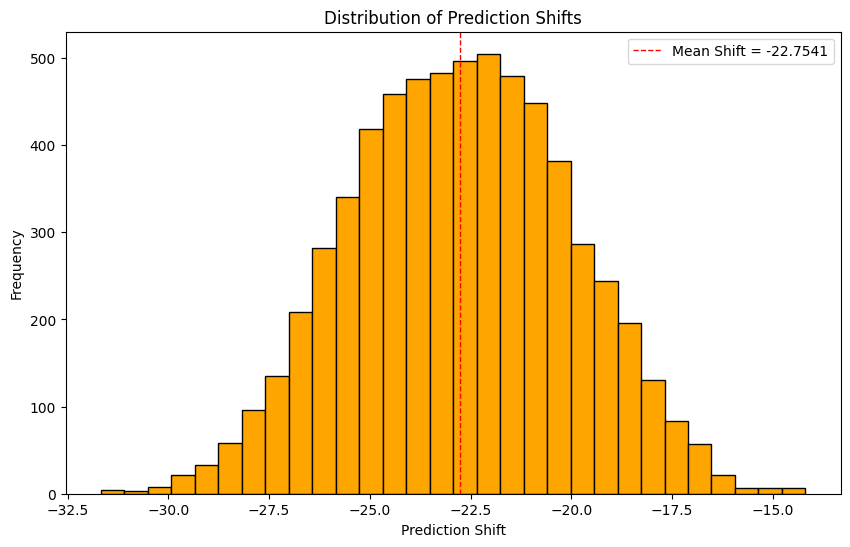

In [15]:
# Vẽ biểu đồ phân phối độ lệch
plt.figure(figsize=(10, 6))
plt.hist(df_adversarial['prediction_shift'], bins=30, color='orange', edgecolor='black')
plt.axvline(mean_shift, color='red', linestyle='dashed', linewidth=1, label=f'Mean Shift = {mean_shift:.4f}')
plt.title('Distribution of Prediction Shifts')
plt.xlabel('Prediction Shift')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [16]:
# Tính xác suất sự kiện hiếm trong dữ liệu đối nghịch
df_adversarial['rare_event_adversarial'] = np.where(df_adversarial['adversarial_prediction'] < low_score_threshold, 1, 0)
adversarial_rare_event_prob = df_adversarial['rare_event_adversarial'].mean()

# So sánh xác suất hiếm
print("Xác suất sự kiện hiếm ban đầu:", df['rare_event'].mean())
print("Xác suất sự kiện hiếm trong dữ liệu đối nghịch:", adversarial_rare_event_prob)


Xác suất sự kiện hiếm ban đầu: 0.08905613044841643
Xác suất sự kiện hiếm trong dữ liệu đối nghịch: 1.0
